In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
from core.ODEDataset import  ODEDataset
from utils import cleaning

In [ ]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 128
EPOCHS = 5000
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)
LOSS = tf.keras.losses.BinaryCrossentropy()
PATIENCE = 50
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_f2_score',    # Metric to monitor (e.g., validation loss)
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',
    start_from_epoch=250
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f2_score',  # Metric to monitor
    factor=0.9,          # Reduce learning rate by this factor (50%)
    patience=PATIENCE,          # Wait for 3 epochs of no improvement
    min_lr=1e-6,          # Minimum learning rate
    mode='max'
)

CALLBACKS = [
    EARLY_STOPPING, 
    # reduce_lr
]



In [4]:

Features = [
    #    'Education_level_HHH',
    'Education_level_HHH_Doctoral or equivalent level',
    'Education_level_HHH_Lower secondary education',
    "Education_level_HHH_Master's or equivalent level",
    'Education_level_HHH_No schooling',
    'Education_level_HHH_Not elsewhere classified',
    'Education_level_HHH_Other',
    'Education_level_HHH_Post-secondary non-tertiary education',
    'Education_level_HHH_Primary education',
    'Education_level_HHH_Secondary education',
    'Education_level_HHH_Short-cycle tertiary education',
    'Education_level_HHH_Upper secondary education',
    # 'Socio_status_HHH',
    'Socio_status_HHH_Employee', 'Socio_status_HHH_Employee farm',
    'Socio_status_HHH_Employee non-farm', 'Socio_status_HHH_Employer',
    'Socio_status_HHH_Other', 'Socio_status_HHH_Own-account worker farm',
    'Socio_status_HHH_Own-account worker non-farm',
    'Socio_status_HHH_Unemployed',
    'Socio_status_HHH_Worker not classifiable by status',
    # 'Tariff_payment_frequency',
    'Tariff_payment_frequency_Every 3 months',
    'Tariff_payment_frequency_Every 6 months',
    'Tariff_payment_frequency_Monthly', 'Tariff_payment_frequency_No bill',
    'Tariff_payment_frequency_Other', 'Tariff_payment_frequency_Weekly',

    'HH_with_home_business_Yes',
    'HH_with_home_business_No',
    'HH_with_home_business_missing',

    'Ownership_motorized_vehicle_Yes',
    'Ownership_large_livestock_No',
    'Ownership_motorized_vehicle_missing',

    'Ownership_small_livestock_Yes',
    'Ownership_small_livestock_No',
    'Ownership_small_livestock_missing',

    'Ownership_large_livestock_Yes',
    'Ownership_large_livestock_No',
    'Ownership_large_livestock_missing',

    'Clean_fuel_Yes',
    'Clean_fuel_No',
    'Clean_fuel_missing',

    'Years_of_HHH_in_community',
    'Years_of_HHH_in_community_missing',

    'Dwelling_quality_index',
    'Dwelling_quality_index_missing',

    'Hours_available_electricity',
    'Hours_available_electricity_missing',

    'Measurement_age',
    'Measurement_age_missing',

    'Monthly_expenditure',
    'Monthly_expenditure_missing',

    'Number_of_rooms',
    'Number_of_rooms_missing',
    'Climate_zone_lev_1',
    'Climate_zone_lev_1_missing',

    'Climate_zone_lev_2',
    'Climate_zone_lev_2_missing',

    'Age_HHH',
    'Age_HHH_missing',

    'Number_adults',
    'Number_adults_missing'
]

FEATURE_NUM = len(Features)

THRESHOLD = 0.5

### Metrics

In [5]:
# Custom F2 score metric

def f2_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f2 = (5 * precision * recall) / (4 * precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f2)

def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    return tf.reduce_mean(precision)


def recall(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives

    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return tf.reduce_mean(recall)


def accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)  # True Negatives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives

    accuracy = (tp + tn) / (tp + tn + fp + fn + tf.keras.backend.epsilon())
    return tf.reduce_mean(accuracy)

In [6]:
# OUTPUT =  "Presence_refrigerator/freezer" # {1.0: 0.13849033063006863, 0.0: 0.8615096693699313}
# OUTPUT =  "Presence_iron" # {0.0: 0.7690382552735073, 1.0: 0.23096174472649267}
OUTPUT =  "Presence_fan" # {1.0: 0.25035427491733586, 0.0: 0.7496457250826641}
# OUTPUT =  "Presence_DVD_player" #  {0.0: 0.8856872933396316, 1.0: 0.11431270666036844}
# OUTPUT =  "Presence_radio/stereo" # {1.0: 0.23284005037783376, 0.0: 0.7671599496221663}
# OUTPUT =  "Presence_phone_charger" # {0.0: 0.7842976561219472, 1.0: 0.2157023438780528}
# OUTPUT =  "Presence_TV" # {0.0: 0.8220796266588887, 1.0: 0.17792037334111127}

## Dataset and Feature Selection

In [7]:
path ="./playground/data/combined_dataset_cleaned.csv"
dataset = ODEDataset("combined_dataset_cleaned")
dataset.from_csv(path)
dataset = dataset.apply(cleaning.remove_row(OUTPUT, -1))
dataset = add_one_hot_encoding(dataset)
df = dataset.to_dataframe()

In [8]:
features =df[Features]
target = df[OUTPUT]

In [ ]:
features.head()

In [10]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler()
x_train, y_train = sampler.fit_resample(x_train, y_train )
print(x_train.shape, y_train.shape)

In [ ]:
y_train.value_counts().plot(kind='pie', title='Training target Distribution')



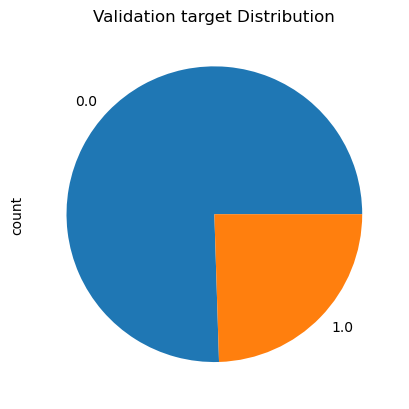

In [ ]:
y_val.value_counts().plot(kind='pie', title='Validation target Distribution')

<Axes: title={'center': 'Testing target Distribution'}, ylabel='count'>

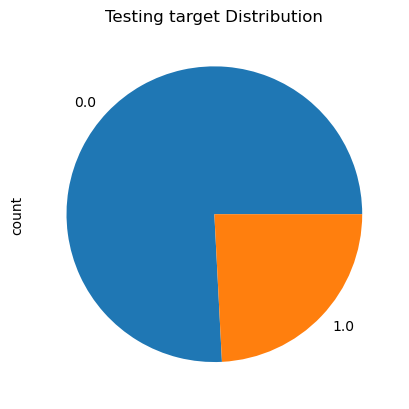

In [ ]:
y_test.value_counts().plot(kind='pie', title='Testing target Distribution')

In [15]:
# add min max normalization to the pipeline
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.math.divide_no_nan(x - tf.reduce_min(x), tf.reduce_max(x) - tf.reduce_min(x))
    return x, y

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32).to_numpy(), y_train.astype(np.float32).to_numpy()))
# train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32).to_numpy(), y_val.astype(np.float32).to_numpy()))
# val_ds = val_ds.map(normalize)
val_ds = val_ds.shuffle(1000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32).to_numpy(), y_test.astype(np.float32).to_numpy()))
# test_ds = val_ds.map(normalize)


## Model

In [17]:
def residual_block(input_tensor, units, activation='relu', regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.Activation(activation)(x)  # Activation after addition
    
    return x


In [18]:
initializer = tf.keras.initializers.GlorotNormal(21)  
regularizer = None #tf.keras.regularizers.l2(0.01)
# Input layer
input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))

units = 128
x = tf.keras.layers.Dense(units,  activation='relu', kernel_regularizer=regularizer)(input_tensor)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
for i in range(4):    
    x = tf.keras.layers.Dense(units,  activation='relu', kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        accuracy,
                        precision,
                        recall,
                        f2_score,
                        tf.keras.metrics.AUC(name='auc'),
                        ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61)]              0         
                                                                 
 dense (Dense)               (None, 128)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

In [19]:
class_weight = {0: 1, 1: 2.0}  # Higher weight for the minority class (1)
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    # class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/5000
50/50 [==============================] - 5s 14ms/step - loss: 0.7256 - accuracy: 0.5271 - precision: 0.6053 - recall: 0.3388 - f2_score: 0.3493 - auc: 0.5591 - val_loss: 0.6898 - val_accuracy: 0.6636 - val_precision: 0.3621 - val_recall: 0.4654 - val_f2_score: 0.4356 - val_auc: 0.6309
Epoch 2/5000
50/50 [==============================] - 0s 8ms/step - loss: 0.7125 - accuracy: 0.5631 - precision: 0.6071 - recall: 0.3962 - f2_score: 0.4029 - auc: 0.5784 - val_loss: 0.6751 - val_accuracy: 0.4285 - val_precision: 0.2739 - val_recall: 0.8105 - val_f2_score: 0.5732 - val_auc: 0.6311
Epoch 3/5000
50/50 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5959 - precision: 0.6128 - recall: 0.3669 - f2_score: 0.3875 - auc: 0.5791 - val_loss: 0.7121 - val_accuracy: 0.4045 - val_precision: 0.2750 - val_recall: 0.8780 - val_f2_score: 0.6054 - val_auc: 0.6704
Epoch 4/5000
50/50 [==============================] - 0s 8ms/step - loss: 0.6819 - accuracy: 0.5619 - pre

KeyboardInterrupt: 

## Visualization & Evaluation

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, cols, index)
plt.plot(history.history['f2_score'])
plt.title('Training F2 score')
plt.ylabel('F2 score')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_f2_score'])
plt.title('Validation F2 score')
plt.ylabel('F2 score')
plt.xlabel('Epoch')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, cols, index)
plt.plot(history.history['precision'])
plt.title('Training Percision')
plt.ylabel('Percision')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_precision'])
plt.title('Validation Percision')
plt.ylabel('Percision')
plt.xlabel('Epoch')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, cols, index)
plt.plot(history.history['recall'])
plt.title('Training Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_recall'])
plt.title('Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')

In [ ]:


train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue', )
plt.plot(val_loss, label='Validation Loss', color='orange',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import classification_report

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred > threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

In [ ]:
train_report = get_classification_report(x_train.astype(np.float32).to_numpy(), y_train.astype(np.float32).to_numpy(), THRESHOLD)
val_report = get_classification_report(x_val.astype(np.float32).to_numpy(), y_val.astype(np.float32).to_numpy(), THRESHOLD)

print("Training")
print(train_report)
print("*" * 100)
print("Validation")
print(val_report)